# Chapter 3: Classification Notes

## 1. MNIST Dataset

In [66]:
# Fetch MNIST digit dataset

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

__Notes on `sklearn` dictionary structure__:
   - `DESCR`: describes dataset
   - `data`: array; one row per instance, one col per feature
   - `target`: array w/labels

In [67]:
# Assign datasets

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [68]:
y.shape

(70000,)

- 70,000 images, 784 features
- 784: $28 \times 28 \times 1$ for BW img

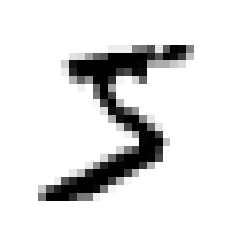

In [69]:
# Can reshape img to 28x28 array and plot with matplotlib

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [70]:
y[0] # label should be 5 -- label is a string!

'5'

In [71]:
# Cast y as int

y = y.astype(np.uint8)

In [72]:
# Create train, test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [73]:
60000/X.shape[0]

0.8571428571428571

## 2. Training a Binary Classifier

### 2.0 Setup

Start with single-class; consider a '5' classifier

In [74]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [75]:
# Try SGD classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
sgd_clf.predict([some_digit]) # See if the known 5 is a 5

array([ True])

__Notes on default SGD classifier__ :
   - Uses hinge loss
   - L2 penalty by default
   - Linear classifier

### 2.1 Performance Measures

#### 2.1.1 CV

In [77]:
from sklearn.model_selection import cross_val_score

cv_rmse = cross_val_score(sgd_clf, X_train, y_train_5, scoring = "accuracy", cv = 3)

cv_rmse

array([0.95035, 0.96035, 0.9604 ])

In [78]:
# Note: 5 is only 1/10 of the dataset -- class imbalance!

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [79]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy") # naive classifier gets 90% as expected

array([0.91125, 0.90855, 0.90915])

#### 2.1.2 Confusion Matrix

In [80]:
# Leave test set alone for now -- use cross_val_predict() from sklearn

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3) # Returns predictions made on each test fold

In [81]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

__Notes on `sklearn` confusion matrix__:
   - Rows = actual, cols = preds
   - First row = negatives, second row = positives

In [82]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### 2.1.3 Precision and Recall

$ \mathrm{Precision} = \frac{TP}{TP + FP}$

$ \mathrm{Recall} = \frac{TP}{TP + FN}$ - sensitivity/true positive

In [83]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [84]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

$F_1 = \frac{2}{ \frac{1}{\mathrm{precision}} + \frac{1}{\mathrm{recall}}}$ = geometric mean

In [85]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred) # favors classifiers with similar precision and recall

0.7325171197343846

### 2.2 ROC Concepts

#### 2.2.1 Precision vs. Recall

- Can alter decision scores for predictions in SGDClassifier

In [86]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [87]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [88]:
y_some_digit_pred

array([ True])

In [89]:
# Raise the threshold

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [90]:
# Can cross-validate for threshold

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                            method = "decision_function")

In [91]:
# Use this decision threshold analysis to plot the ROC

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

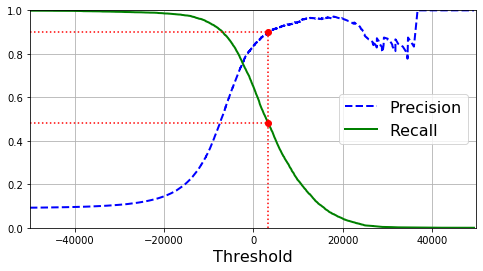

In [92]:
# Use matplot to plot these

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

__Note__ : recall always smoother than precision

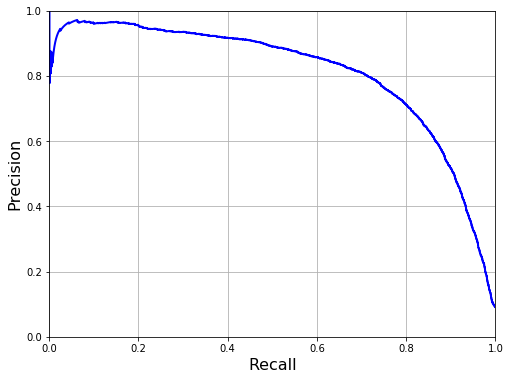

In [93]:
# Another way to view the tradeoff: plot one against the other

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

#### 2.2.2 ROC Curve

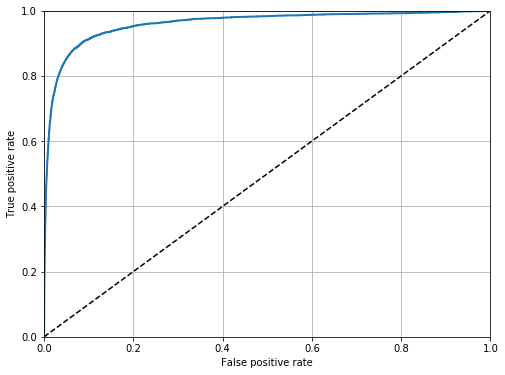

In [94]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.grid(True)
    

plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [95]:
# AUC score

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

__Notes on F1 vs. AUC__:
   - Prefer $F_1$ when positive class is rare, or when care more about false positives than false negatives
   - Otherwise, ROC probably better

### 2.3 Recap Using Random Forest Classifier

- Random forest DOESN'T have `decision_function()` method -- use `predict_proba()`
- Returns array containing row per instance and column per class, with output probs

In [96]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rschm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [98]:
y_scores_forest = y_probas_forest[:, 1] # prob of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

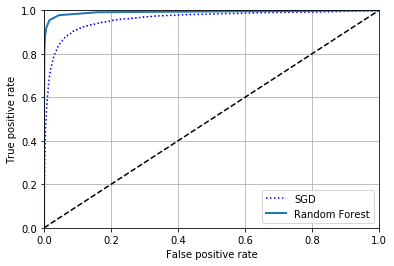

In [99]:
# Plot the ROC curve

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plt.legend(loc = "lower right")
plt.show() # The random forest wins out here

In [100]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## 3. Multiclass Classification